In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from scipy import stats
import jenkspy
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import pyodbc

In [11]:
cnx: pyodbc.Connection = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DWH;"
    "Database=dwOper;"
    "Trusted_Connection=yes;")

In [12]:
query = """
    SELECT p.PlayerID,
       SUM(p.OriginalAmount) Amount,
       SUM(p.PaymentCount) Counts,
       CAST(p.PaymentDate AS DATE) AS Date
    FROM [PartnersReport].[TOTOGAMINGAM].[View_FACT_Payment] p
        INNER JOIN [PartnersReport].[dbo].[DIM_PaymenSystemName] pn ON
            pn.PaymentSystemId=p.PaymentSystemId AND pn.[SourceID]=p.SourceID
    WHERE p.Paymenttype=2
      AND p.SourceID=2
      AND p.PaymentDate >='2022-01-01'
      AND p.PaymentDate < CAST(GETDATE() as date)
    GROUP BY p.PlayerID, CAST(p.PaymentDate AS DATE)
"""

In [13]:
df = pd.read_sql(query, cnx)
cnx.close()

In [14]:
df.head()

,PlayerID,Amount,Counts,Date
0,100383759,3000.0,1,2022-05-25
1,101109981,4850.0,1,2022-06-10
2,100753127,2000.0,1,2022-12-02
3,100706377,22400.0,4,2022-10-10
4,100962514,1000.0,1,2023-01-07


In [15]:
df['Date'] = pd.to_datetime(df['Date'])
anchorDate = dt.datetime(2023,3,7)
rfm = df.groupby('PlayerID').agg({   'Date'  : lambda x: (anchorDate - x.max()).days,
                                     'Counts': lambda x: len(x),
                                     'Amount' : lambda x: x.sum()})

In [16]:
rfm.head()

,Date,Counts,Amount
PlayerID,,,
100377550,4,163,1169933.0
100377551,12,68,640362.0
100377552,257,2,300.0
100377553,213,71,207244.0
100377555,158,3,6500.0


In [17]:
rfm.head()

,Date,Counts,Amount
PlayerID,,,
100377550,4,163,1169933.0
100377551,12,68,640362.0
100377552,257,2,300.0
100377553,213,71,207244.0
100377555,158,3,6500.0


In [18]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [19]:
rfm.head()

,Recency,Frequency,Monetary
PlayerID,,,
100377550,4,163,1169933.0
100377551,12,68,640362.0
100377552,257,2,300.0
100377553,213,71,207244.0
100377555,158,3,6500.0


In [20]:
rfm_segmentation = rfm.copy()

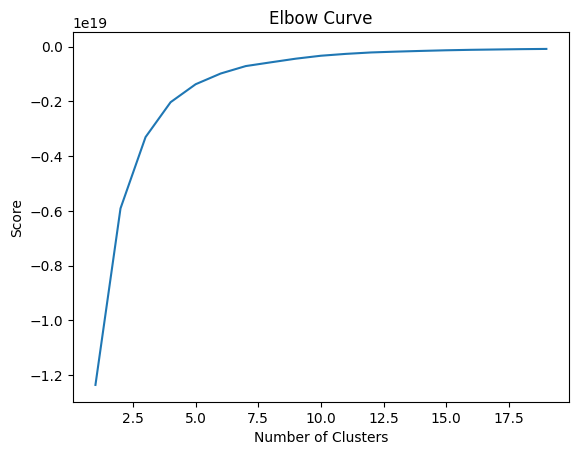

In [21]:
from sklearn.cluster import KMeans
# get right number of cluster for K-means so we neeed to loop from 1 to 20 number of cluster and check score.
#Elbow method is used to represnt that. 
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(rfm_segmentation).score(rfm_segmentation) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [22]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(rfm_segmentation)

In [23]:
rfm_segmentation['cluster'] = kmeans.labels_

<AxesSubplot: xlabel='cluster', ylabel='Recency'>

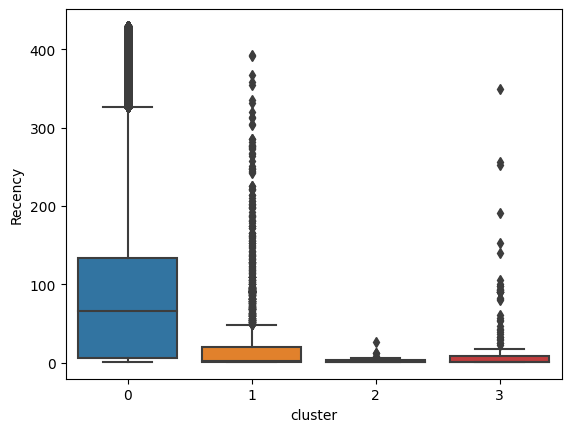

In [28]:
sns.boxplot(x=rfm_segmentation.cluster,y=rfm_segmentation.Recency)

<AxesSubplot: xlabel='cluster', ylabel='Monetary'>

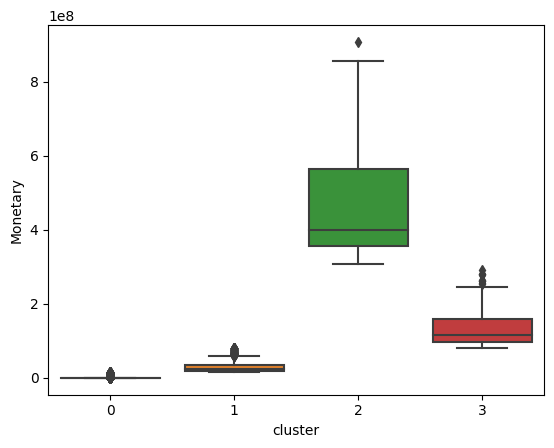

In [30]:
sns.boxplot(x=rfm_segmentation.cluster,y=rfm_segmentation.Monetary)

In [31]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)

#lower the recency, good for store..
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)

#higher value of frequency and monetary lead to a good consumer. here higher value = 1 in reverse way.

def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [32]:
'''
quantile is like 25% , 50% and 75% level of values. example if we have 100 values first 25 in 1st quartile 25% 
then second contain next 25% which is 50% and there after next 25% which is 75% and 4th quartile is more than 75% 
values.
'''
quantile = rfm.quantile(q=[0.25,0.5,0.75])
quantile

,Recency,Frequency,Monetary
0.25,6.0,6.0,9327.145
0.50,64.0,25.0,63860.000
0.75,133.0,79.0,362862.250


In [34]:
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore,args=('Recency',quantile))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantile))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantile))

In [35]:
quantile.to_dict()

{'Recency': {0.25: 6.0, 0.5: 64.0, 0.75: 133.0},
 'Frequency': {0.25: 6.0, 0.5: 25.0, 0.75: 79.0},
 'Monetary': {0.25: 9327.145, 0.5: 63860.0, 0.75: 362862.25}}

In [36]:
#calculate RFM score..

rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore
PlayerID,,,,,,,,
100377550,4,163,1169933.0,0,1,1,1,111
100377551,12,68,640362.0,0,2,2,1,221
100377552,257,2,300.0,0,4,4,4,444
100377553,213,71,207244.0,0,4,2,2,422
100377555,158,3,6500.0,0,4,4,4,444


In [37]:
'''
Another possibility is to combine the scores to create one score (eg. 4+1+1). This will create a score 
between 3 and 12. Here the sdvantage is that each of the scores got same importance. However some scores 
will have many sgements as constituents (eg - 413 ad 431)
'''

rfm_segmentation['Total_score'] = rfm_segmentation['R_Quartile'] + rfm_segmentation['F_Quartile'] + \
rfm_segmentation['M_Quartile']

In [38]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total_score
PlayerID,,,,,,,,,
100377550,4,163,1169933.0,0,1,1,1,111,3
100377551,12,68,640362.0,0,2,2,1,221,5
100377552,257,2,300.0,0,4,4,4,444,12
100377553,213,71,207244.0,0,4,2,2,422,8
100377555,158,3,6500.0,0,4,4,4,444,12


In [39]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==1]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==1]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='134']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='344']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))

Best Customers:  24743
Loyal Customers:  60235
Big Spenders:  60251
Almost Lost:  1196
Lost Customers:  9867
Lost Cheap Customers:  25870


In [40]:
rfm_segmentation.sort_values(by=['RFMScore', 'Monetary'], ascending=[True, False])

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total_score
PlayerID,,,,,,,,,
100817596,3,239,907086130.0,2,1,1,1,111,3
101020030,3,170,856730821.0,2,1,1,1,111,3
100716696,1,150,637279587.0,2,1,1,1,111,3
100391664,1,298,610908062.0,2,1,1,1,111,3
101159017,3,292,598671700.0,2,1,1,1,111,3
...,...,...,...,...,...,...,...,...,...
101238892,146,1,100.0,0,4,4,4,444,12
101238894,149,1,100.0,0,4,4,4,444,12
101239143,146,1,100.0,0,4,4,4,444,12


<AxesSubplot: xlabel='RFMScore'>

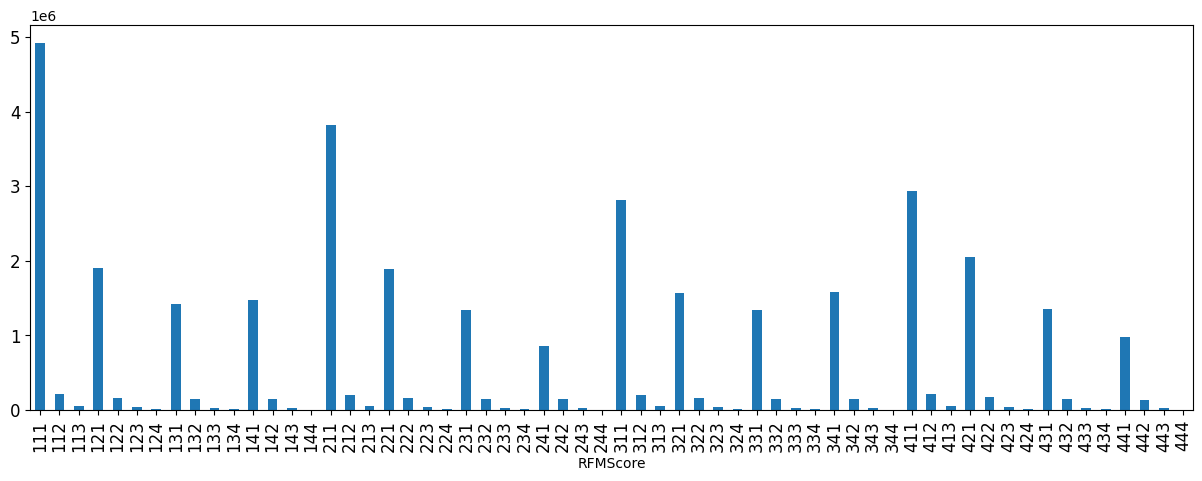

In [44]:
rfm_segmentation.groupby('RFMScore')['Monetary'].mean().round(3).plot(kind='bar', figsize=(15, 5), fontsize=12)

In [45]:
rfm.head()

,Recency,Frequency,Monetary
PlayerID,,,
100377550,4,163,1169933.0
100377551,12,68,640362.0
100377552,257,2,300.0
100377553,213,71,207244.0
100377555,158,3,6500.0


In [46]:
#Date from customer's last purchase.The nearest date gets 5 and the furthest date gets 1.
rfm["recency_score"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
# Total number of purchases.The least frequency gets 1 and the maximum frequency gets 5.
rfm["frequency_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
#Total spend by the customer.The least money gets 1, the most money gets 5.
rfm["monetary_score"]= pd.qcut(rfm["Monetary"],5,labels=[1,2,3,4,5])
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score
PlayerID,,,,,,
100377550,4,163,1169933.0,4,5,5
100377551,12,68,640362.0,4,4,5
100377552,257,2,300.0,1,1,1
100377553,213,71,207244.0,1,4,4
100377555,158,3,6500.0,2,1,2


In [47]:
#RFM - The value of 2 different variables that were formed was recorded as a RFM_SCORE
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str))

In [48]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
PlayerID,,,,,,,,
100377550,4,163,1169933.0,4,5,5,45,loyal_customers
100377551,12,68,640362.0,4,4,5,44,loyal_customers
100377552,257,2,300.0,1,1,1,11,hibernating
100377553,213,71,207244.0,1,4,4,14,at_Risk
100377555,158,3,6500.0,2,1,2,21,hibernating
